#SELF-MADE PRE-PROCESSING MODEL 
* for multi-variable, we might have to run a similar training procedure below but with a different hyper-parameter tuning for each - will talk with Aryan if there's a way to train a "tensor" object & its advantages - otherwise, this is doing the same

* large picture, we would calculate all the weights after training each datasets (x,y,z,andles,blah,blah) and load that into a server to call model.predict

* this takes an input array of the history data we want to forecast forward, and will return an array as well

* after getting all the arrays for one timestep - organize them and run them through the POstureID Algorithm to determine which timestep in future is there a potential bad posture 

* we can determine how long that predicted bad postures can last before we actually report that prediction signal to users (through haptics)

things needed from Tom:
* how many datapoints we need as history, how much as forecast data
* how much to sample down from 100hz data collect
* testing methods to new data

Soon, we can move our model into IMU datasets to test

In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt

import math
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)
mpl.rcParams['figure.figsize'] = 18, 10
mpl.rcParams['lines.linewidth']= 4
mpl.rcParams['lines.markersize'] = 20

In [ ]:
print(tf.__version__)

2.4.0


In [ ]:
#Loading into GDrive
from google.colab import drive
drive.mount('/content/gdrive')

root = 'gdrive/My Drive/Soft Robotics Exosuit Platform/Phase 4: Spring & Summer 2020/Usability/Hardware (Usability)/Motion Sensor Study/Machine Learning Test' 
print("*** root location defined as: " + root)

# ============================================================================= 
# ============================================================================= 
# ============================================================================= 

# Read .csv files and return pd.Dataframe
def findPath(folder,filename):
    #read in CSV file
    data = pd.DataFrame();
    data = pd.read_csv(root + "/upload data/" + folder + filename)
    return data

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
*** root location defined as: gdrive/My Drive/Soft Robotics Exosuit Platform/Phase 4: Spring & Summer 2020/Usability/Hardware (Usability)/Motion Sensor Study/Machine Learning Test


* DataPrep Function (taken from Aug2020 model)
* Removed all label columns because no need / will need to determine with PostureID Algorithm later

In [ ]:
#@title dataprep function
"""
DataPrep Function (combining raw data in Dataframe & return numpy.ndarray)
    > Removed labels of each position (upright, backNotStraight, twist, slouch)
    > Keep just all the datatypes as raw data given in .csv files
"""

# XYZ Positions for three sensors (ChestTop, ChestBot, Tummy)
def prepareData(folder,data1,data2,data3,data4,data5):
    pos_list = [];
    bodyPart = [data1,data2,data3]
    original_y = pd.DataFrame();
    name = ['ChestTop','ChestBottom','Tummy','wholeTorso']

    for i in range(3):
      position = findPath(folder, bodyPart[i])
      position.reset_index(level=0, inplace=True)
      position.columns = ['Time','x_'+name[i],'y_'+name[i],'z_'+name[i],'idk']
      
      #Search for height from data, filtered for only small x-z values
      #replace if we have calibration process to find ChestTop's height
      height = position['y_'+name[i]][0]
      shrink = 0.001
      for j in range(position.shape[0]):
        if(abs(position['x_'+name[i]][j])<= shrink) and (abs(position['z_'+name[i]][j])<= shrink):
          if height < position['y_'+name[i]][j]:
            height = position['y_'+name[i]][j] 
      
      #IMPORTANT FOR THETA DATATYPES 
      original_y['y_'+name[i]] = position['y_'+name[i]]

      position = position.drop(columns=['idk'])
      position = position.drop(columns=['Time'])
      position = position.sub([0,height,0], axis='columns')
      pos_list.append(position)
      
    pos_data = pos_list[0].join(pos_list[1])
    pos_data = pos_data.join(pos_list[2])

    # =========================================================================
    # =========================================================================
    # =========================================================================

    pos_data_np = pos_data.to_numpy()
    original_y_np = original_y.to_numpy()

    radianToDegree = 180/np.pi
    diffFront = np.zeros(position.shape[0])
    diffSide = np.zeros(position.shape[0])
    count = 0

    for i in range(position.shape[0]):
      front1 = math.atan( (pos_data_np[i,0]-pos_data_np[i,3]) / (original_y_np[i,0]-original_y_np[i,1]) ) * radianToDegree
      front2 = math.atan( (pos_data_np[i,3]-pos_data_np[i,6]) / (original_y_np[i,1]-original_y_np[i,2]) ) * radianToDegree
      diffFront[i] = front1 - front2;

      side1 = math.atan( (pos_data_np[i,2]-pos_data_np[i,5]) / (original_y_np[i,0]-original_y_np[i,1]) ) * radianToDegree
      side2 = math.atan( (pos_data_np[i,5]-pos_data_np[i,8]) / (original_y_np[i,1]-original_y_np[i,2]) ) * radianToDegree
      diffSide[i] = side1 - side2
    diffFront = pd.Series(diffFront)
    diffSide = pd.Series(diffSide)

    theta_data = pd.concat([diffFront, diffSide], axis=1)
    theta_data.columns = ['front(deg)','side(deg)']

    # =========================================================================
    # =========================================================================
    # =========================================================================

    # For Chest Angle = only keep anterior and rotate
    chest = findPath(folder,data4)
    chest.reset_index(level=0, inplace=True)
    chest.columns = ['Time','anterior_Chest','lateral','rotate_Chest','idk']
    chest = chest.drop(columns=['idk'])
    chest = chest.drop(columns=['Time'])
    chest = chest.drop(columns=['lateral'])

    # For Chest Angle = only keep anterior and rotate
    hip = findPath(folder,data5)
    hip.reset_index(level=0, inplace=True)
    hip.columns = ['Time','anterior_Hip','lateral','rotate_Hip','idk']
    hip = hip.drop(columns=['idk'])
    hip = hip.drop(columns=['Time'])
    hip = hip.drop(columns=['lateral'])
    hip = hip.drop(columns=['rotate_Hip'])

    final = pos_data.join(theta_data)
    final = final.join(chest)
    final = final.join(hip)

    return final

In [ ]:
df = prepareData("July31_Trial1/",
                  "Positions_ChestTop.csv",
                  "Positions_ChestBottom.csv",
                  "Positions_Tummy.csv",
                  "Angles_Chest.csv",
                  "Angles_Hip.csv")
df.head()

,x_ChestTop,y_ChestTop,z_ChestTop,x_ChestBottom,y_ChestBottom,z_ChestBottom,x_Tummy,y_Tummy,z_Tummy,front(deg),side(deg),anterior_Chest,rotate_Chest,anterior_Hip
0,-0.025,-0.002,0.023,-0.017,-0.001,0.012,-0.008,0.0,0.002,-1.534924,2.937525,6.249,-0.925,-1.935
1,-0.025,-0.002,0.023,-0.017,-0.001,0.012,-0.008,0.0,0.002,-1.534924,2.937525,6.257,-0.928,-1.938
2,-0.025,-0.002,0.023,-0.017,-0.001,0.012,-0.008,0.0,0.002,-1.534924,2.937525,6.267,-0.932,-1.943
3,-0.025,-0.002,0.023,-0.017,-0.001,0.012,-0.008,0.0,0.002,-1.534924,2.937525,6.279,-0.938,-1.947
4,-0.025,-0.002,0.023,-0.017,-0.001,0.012,-0.008,0.0,0.002,-1.534924,2.937525,6.291,-0.945,-1.952


In [ ]:
#@title Feature Selection (x_ChestTop data)
feature = list(df.columns.values)
selected = feature[0]

#keeping temp = x_ChestTop data for now 
chestTop = df[feature[0:2]]
df_chestTop = pd.DataFrame(data=chestTop[0:])

In [ ]:
df_chestTop.head()

,x_ChestTop,y_ChestTop
0,-0.025,-0.002
1,-0.025,-0.002
2,-0.025,-0.002
3,-0.025,-0.002
4,-0.025,-0.002


In [ ]:
#@title Split 70-30
split_data = int(len(df_chestTop) * 0.7)

train_df = df_chestTop.iloc[0:split_data]
test_df = df_chestTop.iloc[split_data:]

train_df.head()

,x_ChestTop,y_ChestTop
0,-0.025,-0.002
1,-0.025,-0.002
2,-0.025,-0.002
3,-0.025,-0.002
4,-0.025,-0.002


In [ ]:
len(train_df.columns)

2

#BUILDING THE FORECAST MODEL (currently SingleShot Recurrent Neural Network) 

In [ ]:
in_steps = 8
out_steps = 8

def create_dataset(data, past=1, future=1):
    Xs, ys = [], []
    for i in range(len(data) - past):
      input_width = i + past
      label_width = input_width + future

      v = data.iloc[i:input_width].values
      Xs.append(v) 

      w = data.iloc[input_width:label_width].values
      test = np.zeros(out_steps)
      if(len(w) < out_steps):
        for i in range(out_steps):
          if i < len(w):
            test[i] = w[i]
          else:
            test[i] = w[-1]
        w = test
      ys.append(w)

    return np.array(Xs), np.array(ys)

In [ ]:
#Columns = # of datatypes need to be pre-processed
num_features = len(train_df.columns)

train_list = [train_df.iloc[:,i] for i in range(num_features)]
test_list = [test_df.iloc[:,i] for i in range(num_features)]

In [ ]:
input_train = []
output_train = []
input_test = []
output_test = []

for i in range(len(train_list)):
  in_train, out_train = create_dataset(train_list[i], in_steps, out_steps)
  in_test, out_test = create_dataset(test_list[i], in_steps, out_steps)

  input_train.append(in_train)
  output_train.append(out_train)
  input_test.append(in_test)
  output_test.append(out_test)

In [ ]:
print(output_train[0])
print(type(output_train[0]))

[[-0.025 -0.025 -0.025 ... -0.025 -0.025 -0.025]
 [-0.025 -0.025 -0.025 ... -0.025 -0.025 -0.025]
 [-0.025 -0.025 -0.025 ... -0.025 -0.025 -0.025]
 ...
 [-0.154 -0.152 -0.151 ... -0.151 -0.151 -0.151]
 [-0.152 -0.151 -0.151 ... -0.151 -0.151 -0.151]
 [-0.151 -0.151 -0.151 ... -0.151 -0.151 -0.151]]
<class 'numpy.ndarray'>


In [ ]:
def create_tensor(dataset_list):
  tensor_list = [];
  for i in range(len(dataset_list)):
    dataset_to_tensor = tf.expand_dims(dataset_list[i], axis=2)
    tensor_list.append(dataset_to_tensor)

  result = tf.concat([tensor_list[i] for i in range(len(tensor_list))], axis=2)

  return result

In [ ]:
history_train = create_tensor(input_train)
future_train = create_tensor(output_train)

In [ ]:
print(history_train.get_shape())
print(future_train.get_shape())

print(history_train[0])

(41991, 8, 2)
(41991, 8, 2)
tf.Tensor(
[[-0.025 -0.002]
 [-0.025 -0.002]
 [-0.025 -0.002]
 [-0.025 -0.002]
 [-0.025 -0.002]
 [-0.025 -0.002]
 [-0.025 -0.002]
 [-0.025 -0.002]], shape=(8, 2), dtype=float64)


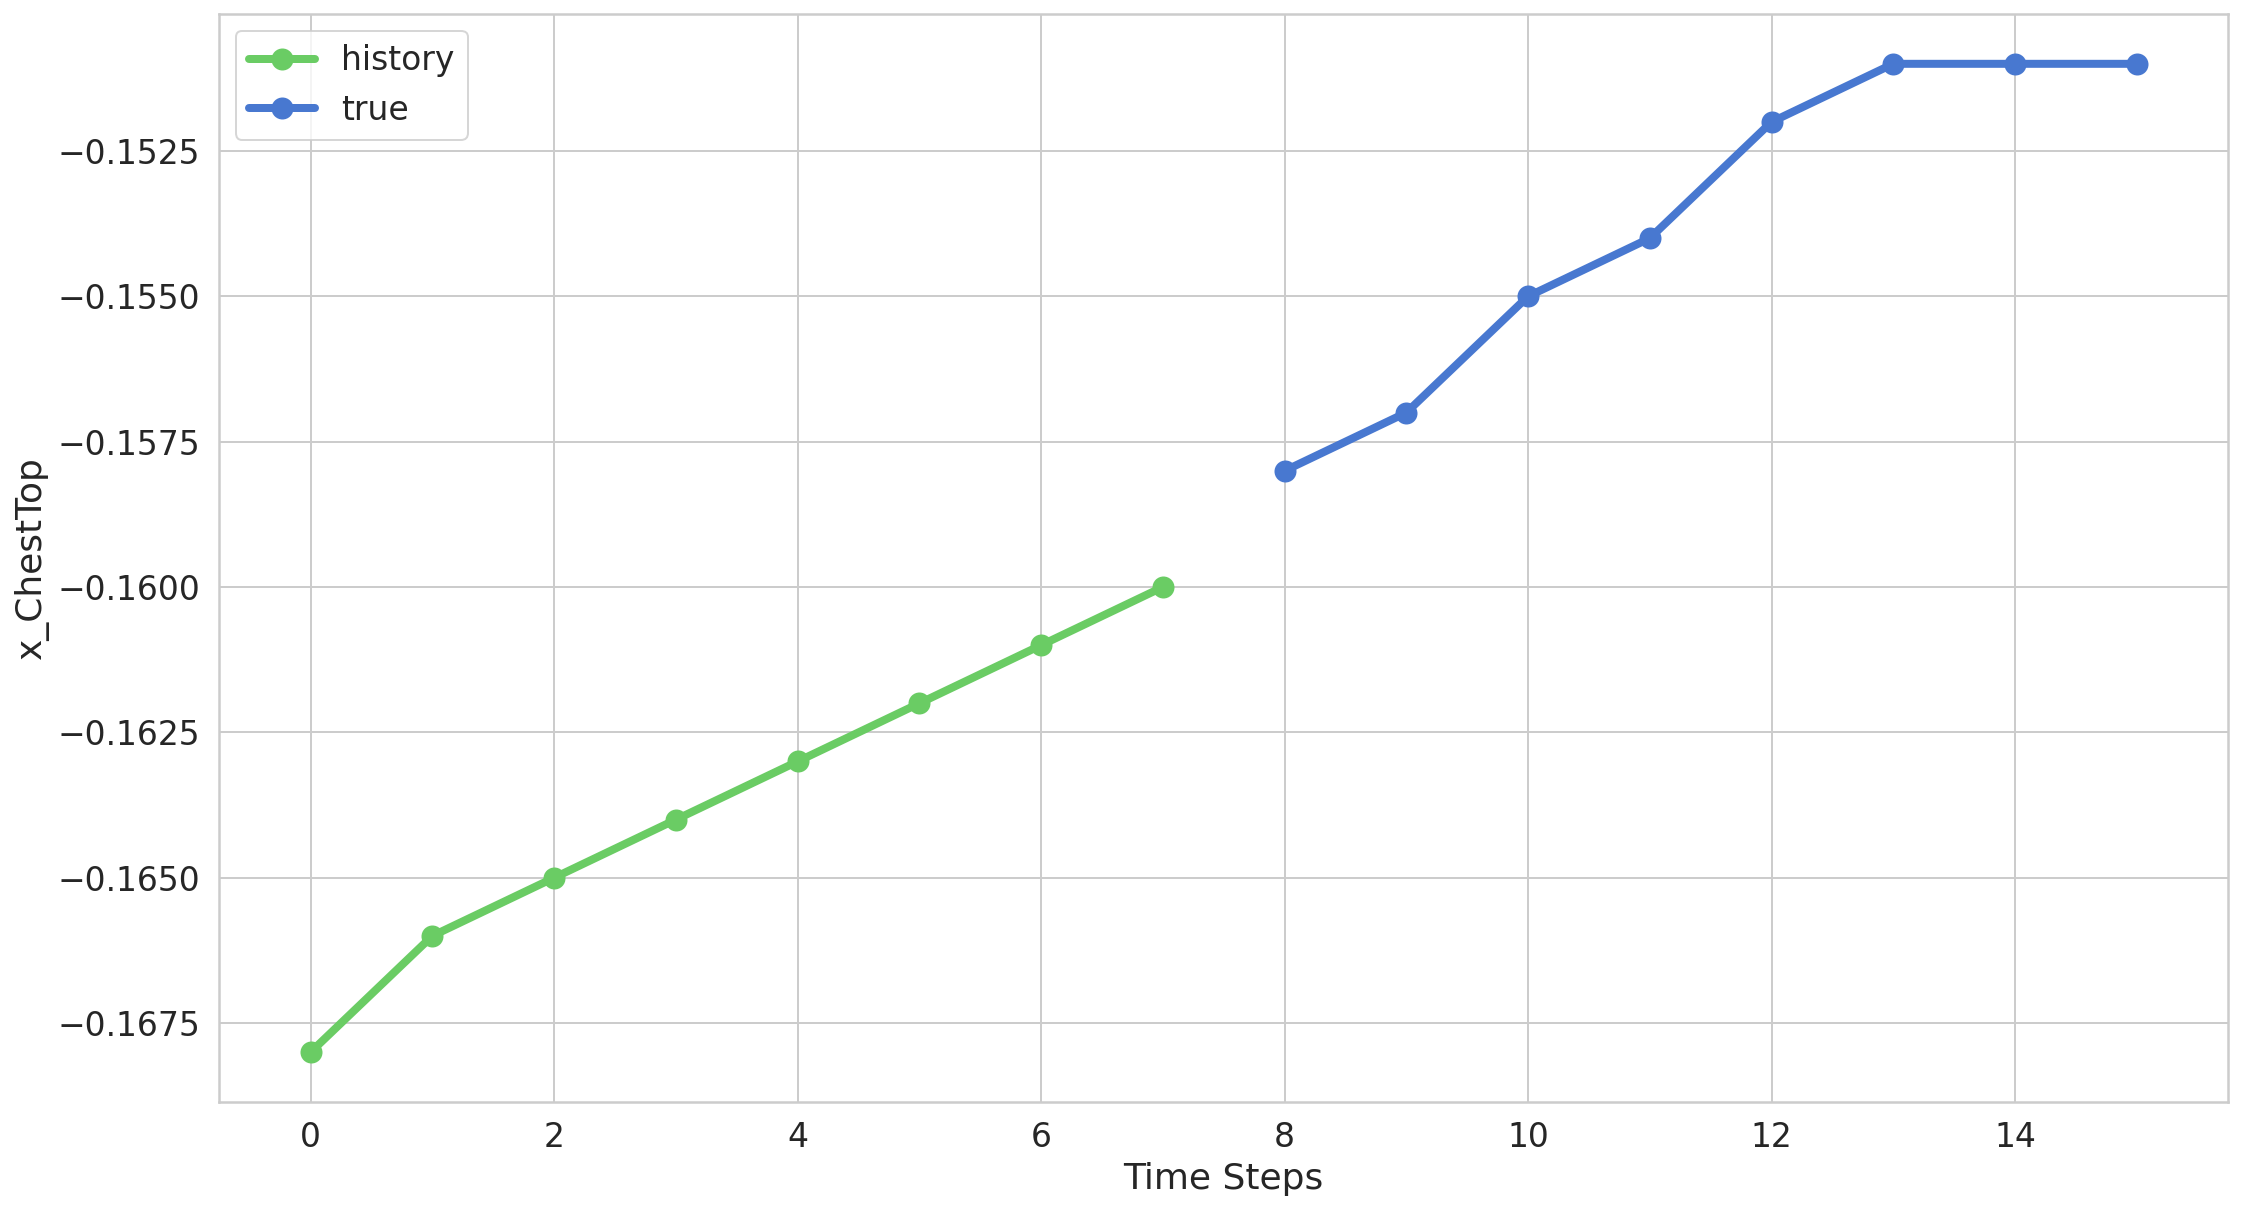

In [ ]:
body = 0
idx = len(train_df)-out_steps-6

plt.plot(np.arange(0, len(input_train[body][idx])), input_train[body][idx], 'g', marker='.', label="history")
plt.plot(np.arange(len(input_train[body][idx]), len(input_train[body][idx]) + len(output_train[body][idx])), output_train[body][idx], 'b', marker='.', label="true")
plt.ylabel(feature[body])
plt.xlabel('Time Steps')
plt.legend()
plt.show()

In [ ]:
model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(128, return_sequences=False),

    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(out_steps, kernel_initializer=tf.initializers.zeros),
])

In [ ]:
MAX_EPOCHS = 50

model.compile(loss=tf.losses.MeanSquaredError(),
              optimizer=tf.optimizers.Adam())

history = model.fit(history_train, future_train, 
                    epochs=MAX_EPOCHS,
                    batch_size=16,
                    validation_split=0.2)

Epoch 1/50


ValueError: ignored